# **PLS (Partial Least Square)를 이용한 Odor 분석**

---

In [76]:
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [77]:
%%R
package_version(R.version)

[1] ‘4.1.1’


In [78]:
%%R

.libPaths("/content/drive/MyDrive/R packages")
.libPaths()

[1] "/content/drive/MyDrive/R packages" "/usr/local/lib/R/site-library"    
[3] "/usr/lib/R/site-library"           "/usr/lib/R/library"               


## **0. Packages Installation**

In [79]:
%%R

# install.packages("corrplot")                  
# install.packages("PerformanceAnalytics")      # 상관분석 시각화
# install.packages("pls")                       # pls
# install.packages("caret")         
# install.packages("mice")        # M.I 결측치 대체
# install.packages("stringr")
# install.packages("devtools")
# install.packages("lmtest")      # Durbin-Watson test (잔차의 독립성)
# install.packages("glmnet")      # Ridge, Lasoo and Elastic Net
# install.packages("Boruta")
# install.packages("car")         # 다중공선성
# install.packages("Metrics")     # RMSE, MAPE
# install.packages("DAAG")        # CV lm

library(DAAG)
library(Metrics)
library(car)
library(Boruta)
library(glmnet)
library(lmtest)
library(devtools)
library(mice)
library(stringr)
library(corrplot)
library(PerformanceAnalytics)
library(pls)
library(caret)

**plsVarSel은  R version 4.0.5에서 지원하지 않으므로, Version을 지정해 다운해야된다.**

In [80]:
%%R
# install_version("plsVarSel", version = "0.9.6", repos = "http://cran.us.r-project.org")    # VIP
library(plsVarSel)

## **1. Data Preparation**

### **1) Read preprocessed data (odo)**

In [81]:
%%R

odo <- read.csv("drive/MyDrive/PLS_양돈 농가/New_data_preprocessed.csv", fileEncoding = "euc-kr")

### Scaling
odo <- as.data.frame(scale(odo, center = T, scale = T))
head(odo)

          ou        nh3         h2s       mm.1         dms         aca
1 -0.8411369 -1.0345165 -0.54687788 -0.5460465  0.01317853 -0.91595123
2 -0.8411369 -1.0228805 -0.13601504  0.1935757  7.31208325  0.69853283
3 -0.7438537 -0.9550038 -0.68258712 -0.5479616  0.84348581  0.23728812
4  0.3288898 -0.9453071 -0.05135239 -0.5479616  0.01642827 -0.07730957
5 -0.8345637 -0.9142777 -0.13103489 -0.5479616 -0.19415456 -0.23450818
6 -0.5985864 -0.9530644 -0.75504839 -0.5479616 -0.19415456 -0.33455692
         ppa         iba        bta        iva         vla         ph
1 -0.9999332 -0.96213542 -1.0319491 -0.7857508 -0.60131023 -0.5477727
2  1.7245789  1.91478326  2.0112695  1.8033594  1.40080787  0.9227162
3  0.8882999  0.96393037  1.5717432  0.9520721  0.91088996  0.0777298
4  0.4511248  0.34545646  1.1984874  0.5654885  0.15114084 -0.2257213
5  0.1819770  0.13108826  0.7403549  0.4731871  0.04651375 -0.2092467
6 -0.1333233 -0.04240923  0.7671150  0.2275147  0.01565252 -0.3165972
           pc

### **2) Data Visualizations**

#### **- 반응변수 (y)**

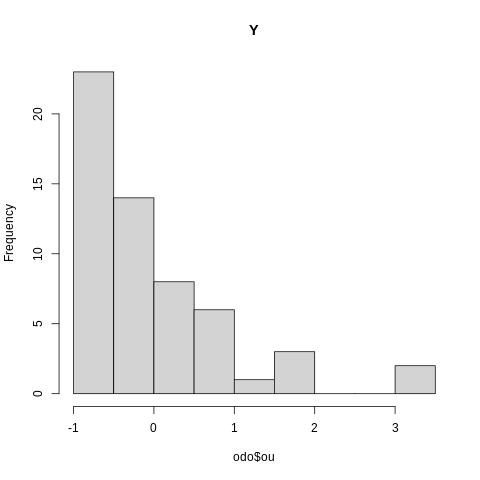

In [82]:
%%R

hist(odo$ou, main="Y")

#### **- Correlation Plot (hitmap)**

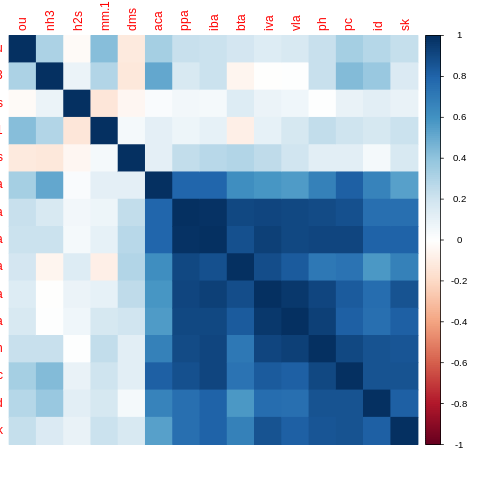

In [83]:
%%R

res <- cor(odo, method = "pearson")
corrplot::corrplot(res, method = "color", order = "original", tl.pos = "r")


#### **- Correlation Plot**

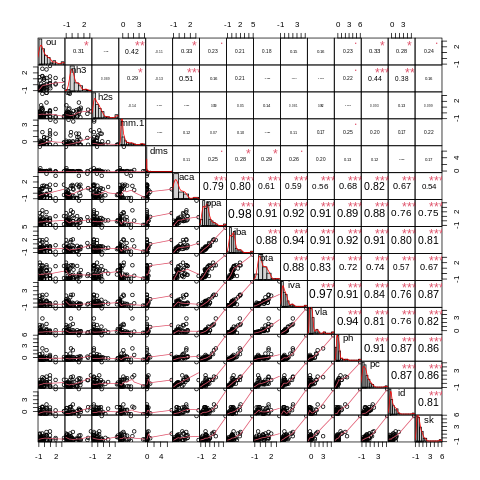

In [84]:
%%R

chart.Correlation(odo, histogram = T, pch = 5)

#### **- Correlation Values**

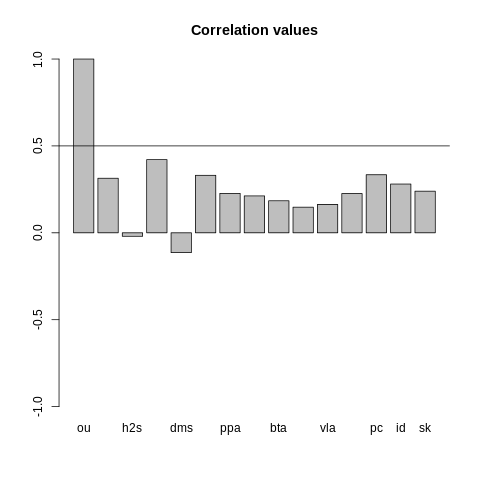

In [85]:
%%R

# 반응변수
barplot(res["ou",], ylim = c(-1,1), main = "Correlation values") ; abline(h = 0.5)

# Total
# print(res)

### **3) 다중 공선성 확인**

In [86]:
%%R

mr <- lm(ou ~ ., data = odo)

VIF <- vif(mr)
print(VIF)

       nh3        h2s       mm.1        dms        aca        ppa        iba 
  4.831220   1.270135   1.554447   1.581643  11.160878  88.300856 158.294582 
       bta        iva        vla         ph         pc         id         sk 
 24.485028 120.712215  48.704390  46.126504  33.085124   6.226120  10.656795 



 9 개 : dms aca ppa iba bta iva vla ph id

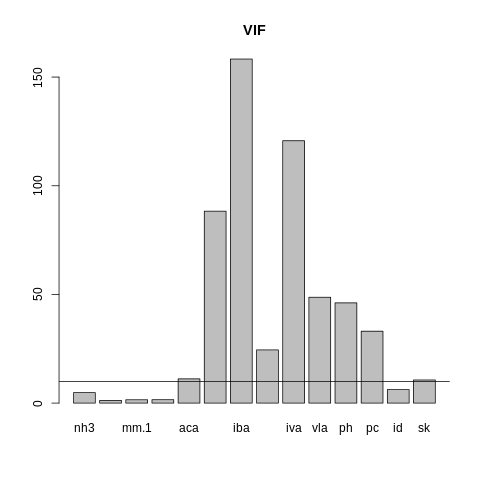

In [87]:
%%R

barplot(VIF, main = "VIF")
abline(h = 10)

cat("\n", sum(VIF > 10), "개 :", names(odo[VIF > 10]))

## **2. Variables Selection**

- Ridge Reg　:　RSS($\beta$)　+　$\lambda \sum_{j=1}^{p}\beta_j^2$

- Lasso Reg　:　RSS($\beta$)　+　$\lambda \sum_{j=1}^{p}|\beta_j|$

- Elastic Net Reg　:　RSS($\beta$)　+　$\lambda_1 \sum_{j=1}^{p}\beta_j^2　+　\lambda_2 \sum_{j=1}^{p}|\beta_j|$

\
- glmnet　:　 RSS($\beta$)　+　$\lambda[(1-\alpha) \sum_{j=1}^{p}\beta_j^2　+　\alpha \sum_{j=1}^{p}|\beta_j|]$

  - $\alpha=1$ : Lasso
  - $\alpha=0$ : Ridge
  - $0<\alpha<1$ : Elastic Net

### **1) Ridge (odor)**

- threshold = 0.05

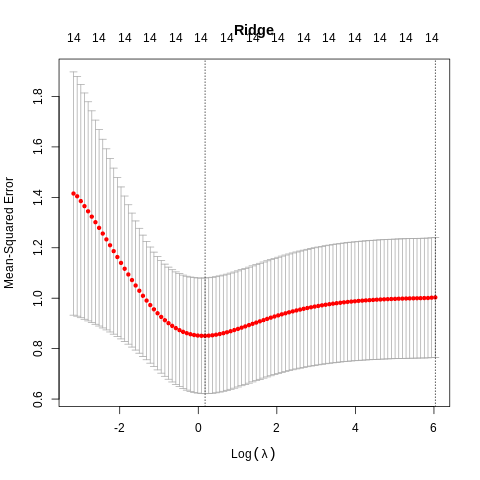

In [88]:
%%R

y <- odo$ou
x <- as.matrix(subset(odo, select = -c(ou)))

cv_ridge <- cv.glmnet(x, y, alpha = 0, parallel = TRUE, standardize = T, type.measure = "mse")

plot(cv_ridge, main = "Ridge")

In [89]:
%%R

print(cv_ridge)


Call:  cv.glmnet(x = x, y = y, type.measure = "mse", parallel = TRUE,      alpha = 0, standardize = T) 

Measure: Mean-Squared Error 

    Lambda Index Measure     SE Nonzero
min    1.2    64  0.8508 0.2295      14
1se  417.4     1  1.0031 0.2379      14


In [90]:
%%R

# Ridge로 구한 회귀 계수
ri_coef <- round(as.matrix(coef(cv_ridge, s = cv_ridge$lambda.min)), 2)
ri_coef

               s1
(Intercept)  0.00
nh3          0.08
h2s         -0.01
mm.1         0.17
dms         -0.07
aca          0.07
ppa          0.02
iba          0.00
bta          0.05
iva         -0.02
vla         -0.02
ph           0.00
pc           0.06
id           0.04
sk           0.03


In [91]:
%%R

# Threshold = 0.05보다 작은 값의 변수는 제거
th <- 0.05

rit_coef <- ri_coef[abs(ri_coef[, 1]) > th, ]
cat("선택된 변수 : ", names(rit_coef), "(", length(rit_coef), "개)", "\n")

del_rit_coef <- ri_coef[abs(ri_coef[, 1]) <= th, ]
cat("제거된 변수 : ", names(del_rit_coef))

선택된 변수 :  nh3 mm.1 dms aca pc ( 5 개) 
제거된 변수 :  (Intercept) h2s ppa iba bta iva vla ph id sk

In [92]:
%%R

odor <- cbind(odo["ou"], odo[names(rit_coef)[2:length(rit_coef)]])
head(odor)

          ou       mm.1         dms         aca          pc
1 -0.8411369 -0.5460465  0.01317853 -0.91595123 -0.94050112
2 -0.8411369  0.1935757  7.31208325  0.69853283  0.80444630
3 -0.7438537 -0.5479616  0.84348581  0.23728812 -0.08575804
4  0.3288898 -0.5479616  0.01642827 -0.07730957 -0.17390461
5 -0.8345637 -0.5479616 -0.19415456 -0.23450818 -0.05561597
6 -0.5985864 -0.5479616 -0.19415456 -0.33455692 -0.29459955


### **2) LASSO (odol)**

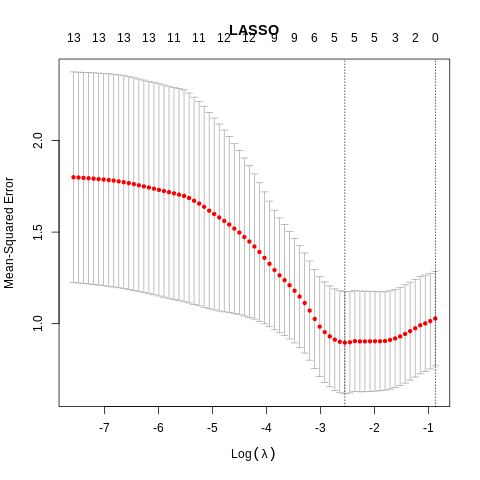

In [93]:
%%R

y <- odo$ou
x <- as.matrix(subset(odo, select = -c(ou)))

cv_lasso <- cv.glmnet(x, y, alpha = 1, parallel = TRUE, standardize = T, type.measure = "mse")

plot(cv_lasso, main = "LASSO")

In [94]:
%%R

print(cv_lasso)


Call:  cv.glmnet(x = x, y = y, type.measure = "mse", parallel = TRUE,      alpha = 1, standardize = T) 

Measure: Mean-Squared Error 

    Lambda Index Measure     SE Nonzero
min 0.0782    19   0.896 0.2784       6
1se 0.4174     1   1.028 0.2586       0


In [95]:
%%R

# LASSO로 구한 회귀 계수
la_coef <- round(as.matrix(coef(cv_lasso, s = cv_lasso$lambda.min)), 2)

la_coef

               s1
(Intercept)  0.00
nh3          0.05
h2s          0.00
mm.1         0.31
dms         -0.08
aca          0.15
ppa          0.00
iba          0.00
bta          0.05
iva          0.00
vla          0.00
ph           0.00
pc           0.02
id           0.00
sk           0.00


In [96]:
%%R

lat_coef <- la_coef[la_coef[, 1] != 0, ]
cat("선택된 변수 : ", names(lat_coef), "(", length(lat_coef), "개)", "\n")

del_lat_coef <- la_coef[la_coef[, 1] == 0, ]
cat("제거된 변수 : ", names(del_lat_coef))

선택된 변수 :  nh3 mm.1 dms aca bta pc ( 6 개) 
제거된 변수 :  (Intercept) h2s ppa iba iva vla ph id sk

In [97]:
%%R

odol <- cbind(odo["ou"], odo[rownames(la_coef)[la_coef > 0][-1]])
head(odol)

          ou       mm.1         aca        bta          pc
1 -0.8411369 -0.5460465 -0.91595123 -1.0319491 -0.94050112
2 -0.8411369  0.1935757  0.69853283  2.0112695  0.80444630
3 -0.7438537 -0.5479616  0.23728812  1.5717432 -0.08575804
4  0.3288898 -0.5479616 -0.07730957  1.1984874 -0.17390461
5 -0.8345637 -0.5479616 -0.23450818  0.7403549 -0.05561597
6 -0.5985864 -0.5479616 -0.33455692  0.7671150 -0.29459955


### **3) Elastic Net (odoe)**

- threshold = 0.0001

In [98]:
%%R 

# elst.Grid <- expand.grid(.alpha = seq(0.01, 1, 0.01),
#                          .lambda = seq(0.01, 1, 0.01))

# best 결과
elst.Grid <- expand.grid(.alpha = seq(0.001, 0.05, 0.01),
                         .lambda = seq(0.1, 1, 0.1))
head(elst.Grid)

  .alpha .lambda
1  0.001     0.1
2  0.011     0.1
3  0.021     0.1
4  0.031     0.1
5  0.041     0.1
6  0.001     0.2


In [99]:
%%R

controlObject <- trainControl(
    method = "repeatedcv",
    repeats = 1,
    number = 5
)

In [100]:
%%R 

elst.Model <- train(
    ou ~.,
    data = odo,
    method = 'glmnet',
    tuneGrid = elst.Grid,
    preProc = c('center',"scale"),
    metric = 'MSE',
    trControl = controlObject
)


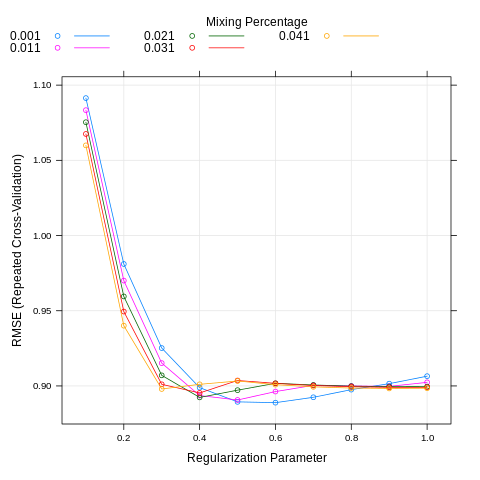

In [101]:
%%R 

plot(elst.Model)

In [102]:
%%R

best <- as.numeric(rownames(elst.Model$bestTune))
elst.Model$bestTune
elst.Model$results$Rsquared[best]

[1] 0.3104235


In [103]:
%%R

# Elastic Net으로 구한 회귀계수
ebb <- elst.Model$finalModel$beta[,best]
round(ebb, 4)

  nh3   h2s  mm.1   dms   aca   ppa   iba   bta   iva   vla    ph    pc    id 
2e-04 0e+00 6e-04 0e+00 2e-04 0e+00 0e+00 0e+00 0e+00 0e+00 0e+00 3e-04 1e-04 
   sk 
0e+00 


In [104]:
%%R

th = 0.0001

ebbt <- ebb[abs(ebb) > th]

cat("선택된 변수 : ", names(ebbt), "(", length(ebbt), "개)", "\n")

del_ebbt <- ebb[abs(ebb) <= th]
cat("제거된 변수 : ", names(del_ebbt))

선택된 변수 :  nh3 mm.1 aca pc ( 4 개) 
제거된 변수 :  h2s dms ppa iba bta iva vla ph id sk

In [105]:
%%R

odoe <- cbind(odo["ou"], odo[names(ebbt)])
head(odoe)

          ou        nh3       mm.1         aca          pc
1 -0.8411369 -1.0345165 -0.5460465 -0.91595123 -0.94050112
2 -0.8411369 -1.0228805  0.1935757  0.69853283  0.80444630
3 -0.7438537 -0.9550038 -0.5479616  0.23728812 -0.08575804
4  0.3288898 -0.9453071 -0.5479616 -0.07730957 -0.17390461
5 -0.8345637 -0.9142777 -0.5479616 -0.23450818 -0.05561597
6 -0.5985864 -0.9530644 -0.5479616 -0.33455692 -0.29459955


### **4) Boruta (odob)**

In [106]:
%%R

set.seed(99)

bo <- Boruta(ou ~ ., data = odo, doTrace = 0)
# names(bo)   # Boruta가 포함하는 결과들의 이름 

# 중요한 변수
bs <- getSelectedAttributes(bo, withTentative = TRUE)
print(bs)

# 중요 변수 조정
roughFixMod <- TentativeRoughFix(bo)

bs2 <- getSelectedAttributes(roughFixMod)
print(bs2)


# 변수 중요도
imps <- attStats(roughFixMod)
imps2 <- imps[imps$decision != "Rejected", c("meanImp","decision")]
print(imps2[order(-imps2$meanImp), ])

[1] "nh3"  "mm.1" "aca"  "ppa"  "iba"  "iva"  "pc"   "id"  
[1] "nh3"  "mm.1" "aca"  "iva"  "pc"   "id"  
      meanImp  decision
aca  7.322387 Confirmed
nh3  6.944029 Confirmed
mm.1 6.202693 Confirmed
id   3.921578 Confirmed
pc   3.648376 Confirmed
iva  3.624607 Confirmed


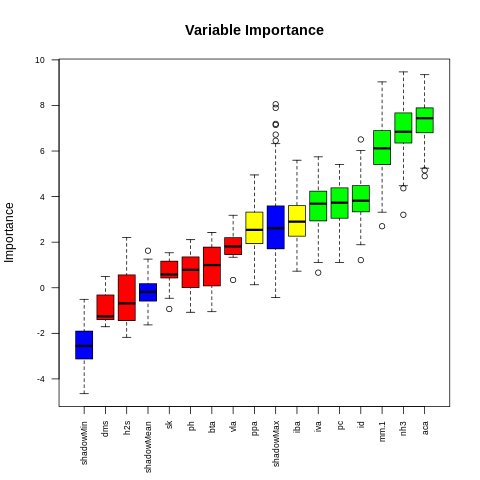

In [107]:
%%R

plot(bo, cex.axis = .7, las = 2, xlab = "", main = "Variable Importance")

In [108]:
%%R

odob <- cbind(odo["ou"], odo[,rownames(imps2)])
head(odob)

          ou        nh3       mm.1         aca        iva          pc
1 -0.8411369 -1.0345165 -0.5460465 -0.91595123 -0.7857508 -0.94050112
2 -0.8411369 -1.0228805  0.1935757  0.69853283  1.8033594  0.80444630
3 -0.7438537 -0.9550038 -0.5479616  0.23728812  0.9520721 -0.08575804
4  0.3288898 -0.9453071 -0.5479616 -0.07730957  0.5654885 -0.17390461
5 -0.8345637 -0.9142777 -0.5479616 -0.23450818  0.4731871 -0.05561597
6 -0.5985864 -0.9530644 -0.5479616 -0.33455692  0.2275147 -0.29459955
          id
1 -0.6386094
2  0.3385144
3 -0.4259413
4  0.8989236
5 -0.6386094
6 -0.6386094


### **5) 다중 공선성 확인**

In [109]:
%%R

mrr <- lm(ou ~ ., data = odor)
mrl <- lm(ou ~ ., data = odol)
mre <- lm(ou ~ ., data = odoe)
mrb <- lm(ou ~ ., data = odob)

VIFR <- vif(mrr)
VIFL <- vif(mrl)
VIFE <- vif(mre)
VIFB <- vif(mrb)

print("Ridge")
print(VIFR)
cat("\n", sum(VIFR > 10), "개 :", names(odo[VIFR > 10]), "\n\n")

print("LASSO")
print(VIFL)
cat("\n", sum(VIFL > 10), "개 :", names(odo[VIFL > 10]), "\n\n")

print("Elastic Net")
print(VIFE)
cat("\n", sum(VIFE > 10), "개 :", names(odo[VIFE > 10]), "\n\n")

print("Boruta")
print(VIFB)
cat("\n", sum(VIFB > 10), "개 :", names(odo[VIFB > 10]))

[1] "Ridge"
    mm.1      dms      aca       pc 
1.049874 1.016477 3.070838 3.163138 

 0 개 :  

[1] "LASSO"
    mm.1      aca      bta       pc 
1.192283 3.070256 2.504143 4.749185 

 0 개 :  

[1] "Elastic Net"
     nh3     mm.1      aca       pc 
1.467471 1.131431 3.445519 3.155263 

 0 개 :  

[1] "Boruta"
      nh3      mm.1       aca       iva        pc        id 
 3.291763  1.138806  3.579450  8.735179 15.553481  4.320433 

 1 개 : dms vla

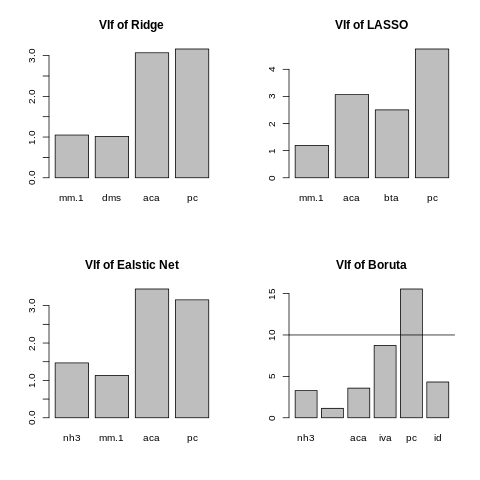

In [110]:
%%R

par(mfrow = c(2,2))
barplot(VIFR, main = "VIf of Ridge") ; abline(h = 10)
barplot(VIFL, main = "VIf of LASSO") ; abline(h = 10)
barplot(VIFE, main = "VIf of Ealstic Net") ; abline(h = 10)
barplot(VIFB, main = "VIf of Boruta") ; abline(h = 10)
par(mfrow = c(1,1))

## **3. PLS**

### **1) Model (pr, prr, prl,pre, prb)**

In [111]:
%%R

### Validation method : Leave-One-Out

pr <- plsr(ou ~ ., data = odo, ncomp = ncol(odo)-1, validation = "LOO")         # 기본
prr <- plsr(ou ~ ., data = odor, ncomp = ncol(odor)-1, validation = "LOO")      # Ridge
prl <- plsr(ou ~ ., data = odol, ncomp = ncol(odol)-1, validation = "LOO")      # LASSO
pre <- plsr(ou ~ ., data = odoe, ncomp = ncol(odoe)-1, validation = "LOO")      # Elastic net
prb <- plsr(ou ~ ., data = odob, ncomp = ncol(odob)-1, validation = "LOO")      # Boruta

### **2) Optimal Components**

Basic :  3 
Ridge :  3 
LASSO :  3 
Elastic net :  3 
Boruta :  3

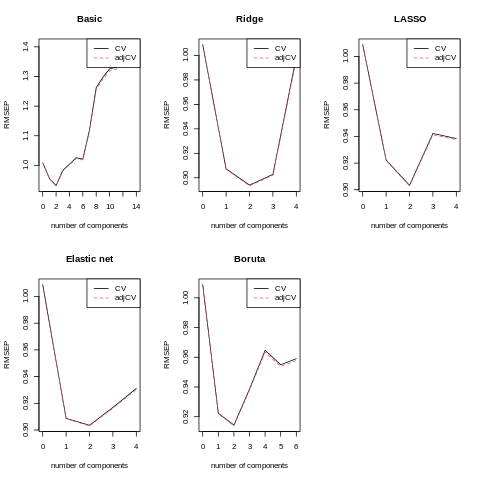

In [112]:
%%R

par(mfrow = c(2,3))
plot(RMSEP(pr), legendpos = "topright", main = "Basic")
plot(RMSEP(prr), legendpos = "topright", main = "Ridge")
plot(RMSEP(prl), legendpos = "topright", main = "LASSO")
plot(RMSEP(pre), legendpos = "topright", main = "Elastic net")
plot(RMSEP(prb), legendpos = "topright", main = "Boruta")
par(mfrow = c(1,1))

# 최적의 ncomp 수 

ocom = which.min(pr$validation$PRESS) + 1
ocomr = which.min(prr$validation$PRESS) + 1
ocoml = which.min(prl$validation$PRESS) + 1
ocome = which.min(pre$validation$PRESS) + 1
ocomb = which.min(prb$validation$PRESS) + 1

cat("Basic : ", ocom, "\n")
cat("Ridge : ", ocomr, "\n")
cat("LASSO : ", ocoml, "\n")
cat("Elastic net : ", ocome, "\n")
cat("Boruta : ", ocomb)

### **3) Loading Value**

#### **- Original**

In [113]:
%%R

print(pr$loadings[ , 1:ocom])

print(pr$Yloadings[ , 1:ocom])

         Comp 1      Comp 2      Comp 3
nh3  0.17771144  0.47052650 -0.72480568
h2s  0.02178893 -0.09868245 -0.03711303
mm.1 0.14459655  0.47751305  0.69016418
dms  0.04558624 -0.30572668  0.07322541
aca  0.32981001  0.03265667 -0.11023140
ppa  0.35972560 -0.26702159  0.14548623
iba  0.37168419 -0.24480010  0.03467135
bta  0.29087534 -0.40376452  0.47368620
iva  0.34301247 -0.33914721  0.18153396
vla  0.34234275 -0.29383509  0.17129073
ph   0.37542190 -0.14989638 -0.12474397
pc   0.38825478 -0.06325405 -0.15419268
id   0.35395398 -0.05737545 -0.41303924
sk   0.34069562 -0.16904405 -0.02401750
   Comp 1    Comp 2    Comp 3 
0.1511078 0.2673954 0.4284588 


#### **- Ridge**

In [114]:
%%R

print(prr$loadings[ , 1:ocomr])

print(prr$Yloadings[ , 1:ocomr])

          Comp 1     Comp 2     Comp 3
mm.1  0.50715061  0.5275490  0.2544105
dms  -0.01573613 -0.5918701  0.4657971
aca   0.62397049 -0.4508336  0.5798070
pc    0.65736224 -0.4205740 -0.7354804
    Comp 1     Comp 2     Comp 3 
0.40047572 0.16105150 0.09123445 


#### **- LASSO**

In [115]:
%%R

print(prl$loadings[ , 1:ocoml])

print(prl$Yloadings[ , 1:ocoml])

        Comp 1     Comp 2      Comp 3
mm.1 0.3932436  0.7223703 -0.09719033
aca  0.5892739 -0.3073151  0.82361775
bta  0.4609715 -0.5462137 -0.06598221
pc   0.6346772 -0.3049144 -0.65655585
   Comp 1    Comp 2    Comp 3 
0.3323638 0.1752937 0.1301300 


#### **- Elastic net**

In [116]:
%%R

print(pre$loadings[ , 1:ocome])

print(pre$Yloadings[ , 1:ocome])

        Comp 1     Comp 2      Comp 3
nh3  0.5090891 -0.1662398 -0.92859052
mm.1 0.4177282  0.7949386  0.04868248
aca  0.5511830 -0.4698316  0.45759147
pc   0.5593073 -0.3803660  0.35791175
    Comp 1     Comp 2     Comp 3 
0.33605782 0.15794076 0.05487556 


#### **- Boruta**

In [117]:
%%R

print(prb$loadings[ , 1:ocomb])

print(prb$Yloadings[ , 1:ocomb])

        Comp 1     Comp 2      Comp 3
nh3  0.3782524  0.2773340 -1.12709339
mm.1 0.3006970  0.6549785  0.55354526
aca  0.4801852 -0.2349898  0.10250712
iva  0.3870814 -0.5102803  0.48542170
pc   0.5264898 -0.3366812  0.07113265
id   0.4837024 -0.3470665 -0.03037879
   Comp 1    Comp 2    Comp 3 
0.2633331 0.2139784 0.1888173 


### **4) New Data Set**

In [118]:
%%R

### Validation method : Leave-One-Out

pr <- plsr(ou ~ ., data = odo, ncomp = ocom, validation = "LOO")         # 기본
prr <- plsr(ou ~ ., data = odor, ncomp = ocomr, validation = "LOO")      # Ridge
prl <- plsr(ou ~ ., data = odol, ncomp = ocoml, validation = "LOO")      # LASSO
pre <- plsr(ou ~ ., data = odoe, ncomp = ocome, validation = "LOO")      # Elastic net
prb <- plsr(ou ~ ., data = odob, ncomp = ocomb, validation = "LOO")      # Boruta

In [119]:
%%R

# New Original
om <- matrix(as.numeric(pr$scores), ncol = ncol(pr$scores))
new_odo <- cbind(odo["ou"], om)
colnames(new_odo) <- c("ou",colnames(pr$scores))

# New Ridge
orm <- matrix(as.numeric(prr$scores), ncol = ncol(prr$scores))
new_odor <- cbind(odo["ou"], orm)
colnames(new_odor) <- c("ou",colnames(prr$scores))

# New LASSO
olm <- matrix(as.numeric(prl$scores), ncol = ncol(prl$scores))
new_odol <- cbind(odo["ou"], olm)
colnames(new_odol) <- c("ou",colnames(prl$scores))

# New Elastic Net
oem <- matrix(as.numeric(pre$scores), ncol = ncol(pre$scores))
new_odoe <- cbind(odo["ou"], oem)
colnames(new_odoe) <- c("ou",colnames(pre$scores))

# New boruta
obm <- matrix(as.numeric(prb$scores), ncol = ncol(prb$scores))
new_odob <- cbind(odo["ou"], obm)
colnames(new_odob) <- c("ou",colnames(prb$scores))

### **5) Correlation Plot**

#### **- Original**

**- Correlation Plot (hitmap)**

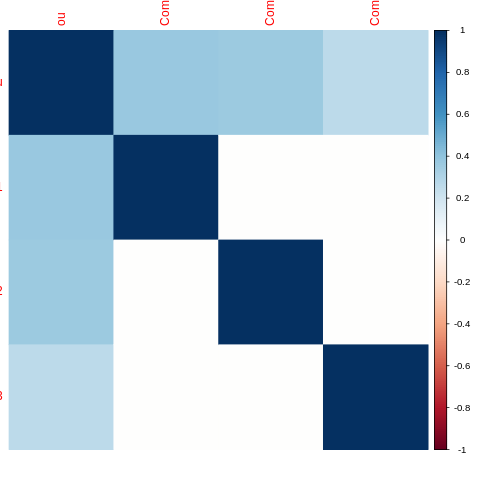

In [120]:
%%R

reso <- cor(new_odo, method = "pearson")
corrplot::corrplot(reso, method = "color", order = "original", tl.pos = "r")


**- Correlation Plot**

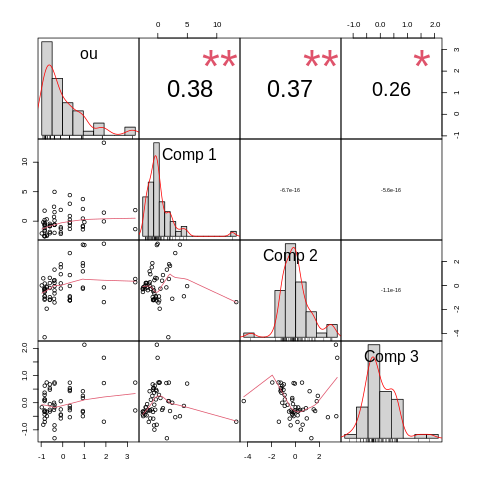

In [121]:
%%R

chart.Correlation(new_odo, histogram = T, pch = 5)

In [122]:
%%R

# 반응변수
print(round(reso["ou",],3))

# Total
# print(reso)

    ou Comp 1 Comp 2 Comp 3 
 1.000  0.376  0.365  0.265 


#### **- Ridge**

**- Correlation Plot (hitmap)**

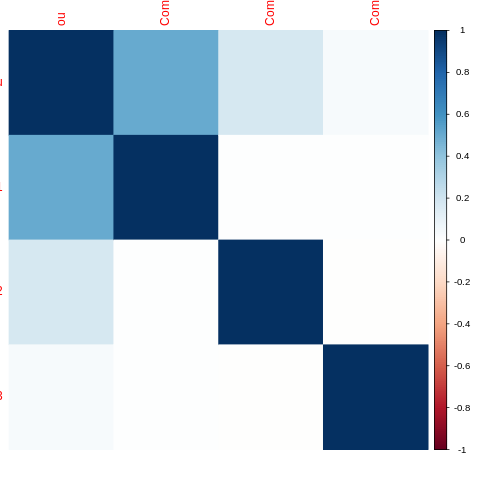

In [123]:
%%R

resr <- cor(new_odor, method = "pearson")
corrplot::corrplot(resr, method = "color", order = "original", tl.pos = "r")


**- Correlation Plot**

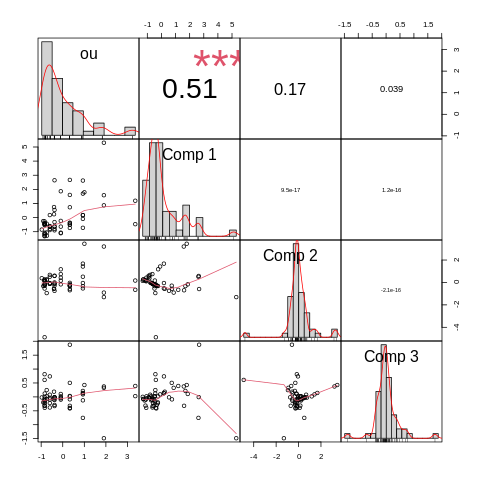

In [124]:
%%R

chart.Correlation(new_odor, histogram = T, pch = 5)

In [125]:
%%R

# 반응변수
print(round(resr["ou",],3))

# Total
# print(resr)

    ou Comp 1 Comp 2 Comp 3 
 1.000  0.507  0.170  0.039 


#### **- LASSO**

**- Correlation Plot (hitmap)**

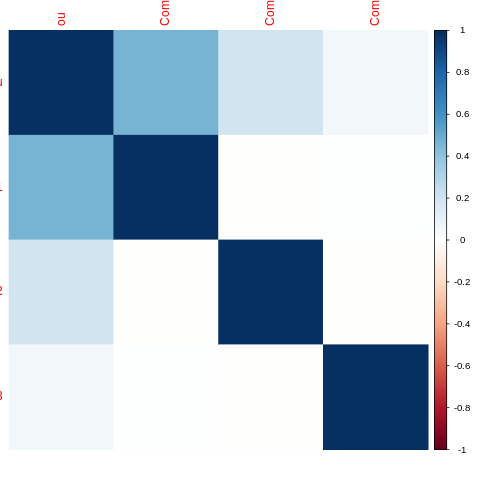

In [126]:
%%R

resl <- cor(new_odol, method = "pearson")
corrplot::corrplot(resl, method = "color", order = "original", tl.pos = "r")


**- Correlation Plot**

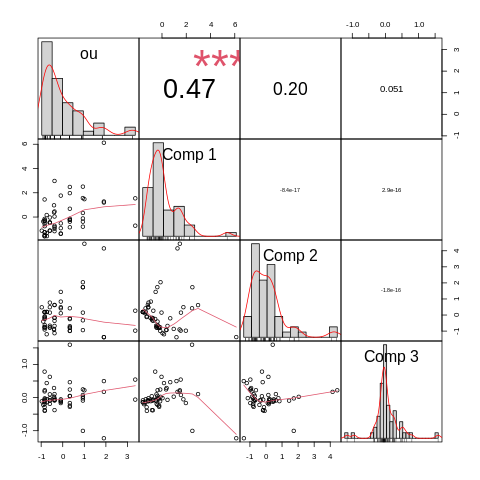

In [127]:
%%R

chart.Correlation(new_odol, histogram = T, pch = 5)

In [128]:
%%R

# 반응변수
print(round(resl["ou",],4))

# Total
# print(resl)

    ou Comp 1 Comp 2 Comp 3 
1.0000 0.4675 0.1987 0.0505 


#### **- Elastic Net**

**- Correlation Plot (hitmap)**

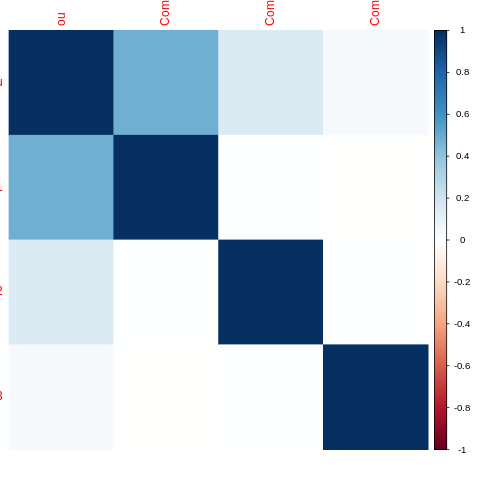

In [129]:
%%R

rese <- cor(new_odoe, method = "pearson")
corrplot::corrplot(rese, method = "color", order = "original", tl.pos = "r")


**- Correlation Plot**

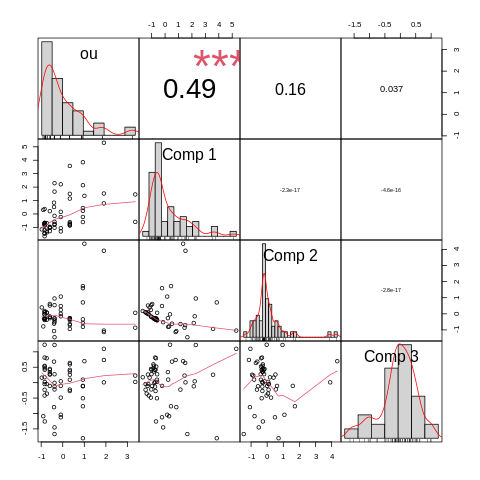

In [130]:
%%R

chart.Correlation(new_odoe, histogram = T, pch = 5)

In [131]:
%%R

# 반응변수
print(round(rese["ou",], 3))

# Total
# print(rese)

    ou Comp 1 Comp 2 Comp 3 
 1.000  0.487  0.158  0.037 


#### **- Boruta**

**- Correlation Plot (hitmap)**

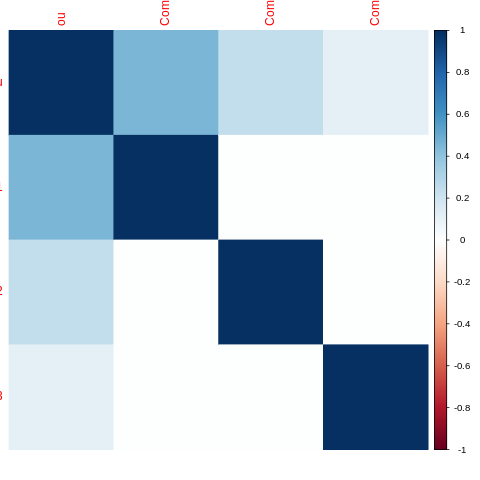

In [132]:
%%R

resb <- cor(new_odob, method = "pearson")
corrplot::corrplot(resb, method = "color", order = "original", tl.pos = "r")


**- Correlation Plot**

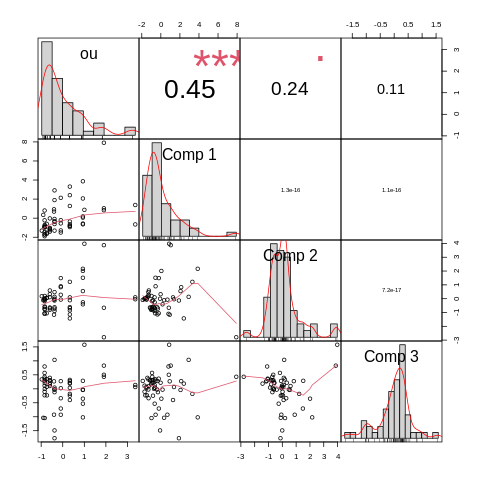

In [133]:
%%R

chart.Correlation(new_odob, histogram = T, pch = 5)

In [134]:
%%R

# 반응변수
print(round(resb["ou",], 3))

# Total
# print(resb)

    ou Comp 1 Comp 2 Comp 3 
 1.000  0.451  0.242  0.110 


#### **TOTAL**

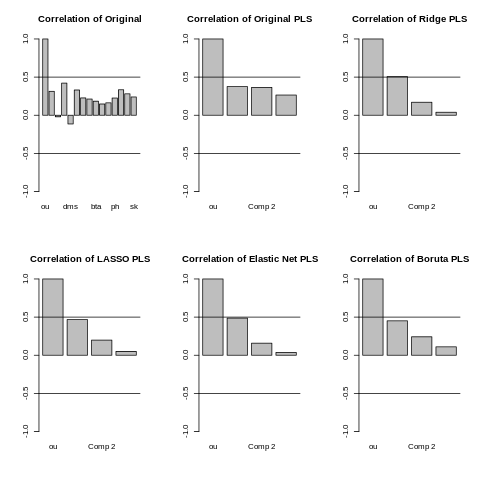

In [135]:
%%R

par(mfrow = c(2,3))
barplot(res["ou",], ylim = c(-1,1), main = "Correlation of Original") ; abline(h = c(-0.5, 0.5))
barplot(reso["ou",], ylim = c(-1,1), main = "Correlation of Original PLS") ; abline(h = c(-0.5, 0.5))
barplot(resr["ou",], ylim = c(-1,1), main = "Correlation of Ridge PLS") ; abline(h = c(-0.5, 0.5))
barplot(resl["ou",], ylim = c(-1,1), main = "Correlation of LASSO PLS") ; abline(h = c(-0.5, 0.5))
barplot(rese["ou",], ylim = c(-1,1), main = "Correlation of Elastic Net PLS") ; abline(h = c(-0.5, 0.5))
barplot(resb["ou",], ylim = c(-1,1), main = "Correlation of Boruta PLS") ; abline(h = c(-0.5, 0.5))
par(mfrow = c(1,1))

### **6) Plots**

#### **- VIP**

In [136]:
%%R

vip <- round(VIP(pr, opt.comp = ocom), 3)
vipr <- round(VIP(prr, opt.comp = ocomr), 3)
vipl <- round(VIP(prl, opt.comp = ocoml), 3)
vipe <- round(VIP(pre, opt.comp = ocome), 3)
vipb <- round(VIP(prb, opt.comp = ocomb), 3)

print("VIP - Basic")
print(sort(vip, decreasing = T))
cat("\n")

print("VIP - Ridge")
print(sort(vipr, decreasing = T))
cat("\n")

print("VIP - LASSO")
print(sort(vipl, decreasing = T))
cat("\n")

print("VIP - Elastic Net")
print(sort(vipe, decreasing = T))
cat("\n")

print("VIP - Boruta")
print(sort(vipb, decreasing = T))

[1] "VIP - Basic"
 mm.1   nh3   bta    ph   iva    pc   aca   vla   iba   ppa    id   dms    sk 
1.783 1.388 1.325 0.975 0.895 0.866 0.855 0.852 0.845 0.811 0.790 0.789 0.718 
  h2s 
0.216 

[1] "VIP - Ridge"
 mm.1    pc   aca   dms 
1.286 1.037 1.011 0.498 

[1] "VIP - LASSO"
 mm.1    pc   aca   bta 
1.301 0.985 0.951 0.659 

[1] "VIP - Elastic Net"
 mm.1    pc   aca   nh3 
1.236 0.929 0.923 0.870 

[1] "VIP - Boruta"
 mm.1    pc   nh3   aca    id   iva 
1.392 0.973 0.965 0.938 0.858 0.753 


In [137]:
%%R

cat("중요한 변수 - Basic : ",  names(vip[which(vip >= 1)]), "(", sum(vip >= 1),"개", ")", "\n")
cat("중요한 변수 - Ridge : ",  names(vipr[which(vipr >= 1)]), "(", sum(vipr >= 1),"개", ")", "\n")
cat("중요한 변수 - LASSO : ",  names(vipl[which(vipl >= 1)]), "(", sum(vipl >= 1),"개", ")", "\n")
cat("중요한 변수 - Elastic Net : ",  names(vipe[which(vipe >= 1)]), "(", sum(vipe >= 1),"개", ")", "\n")
cat("중요한 변수 - Boruta : ",  names(vipb[which(vipb >= 1)]), "(", sum(vipb >= 1),"개", ")")

중요한 변수 - Basic :  nh3 mm.1 bta ( 3 개 ) 
중요한 변수 - Ridge :  mm.1 aca pc ( 3 개 ) 
중요한 변수 - LASSO :  mm.1 ( 1 개 ) 
중요한 변수 - Elastic Net :  mm.1 ( 1 개 ) 
중요한 변수 - Boruta :  mm.1 ( 1 개 )

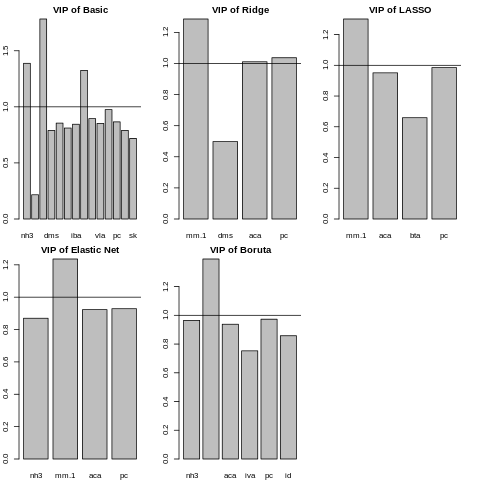

In [138]:
%%R

par(mfrow = c(2,3), mar = c(2,2,2,2))   # mar : plot inner margin
barplot(vip, main = "VIP of Basic") ; abline(h = 1)
barplot(vipr, main = "VIP of Ridge") ; abline(h = 1)
barplot(vipl, main = "VIP of LASSO") ; abline(h = 1)
barplot(vipe, main = "VIP of Elastic Net") ; abline(h = 1)
barplot(vipb, main = "VIP of Boruta") ; abline(h = 1)
par(mfrow = c(1,1))

#### **- Biplot**

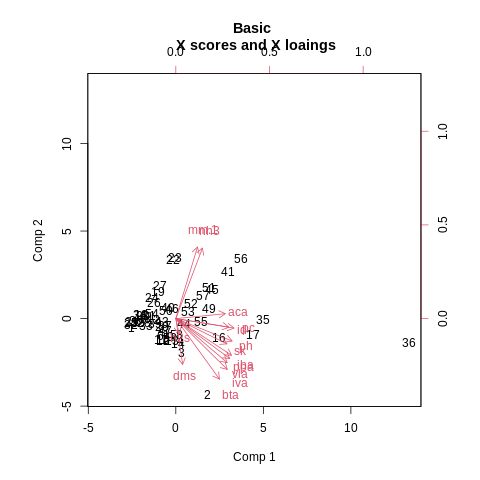

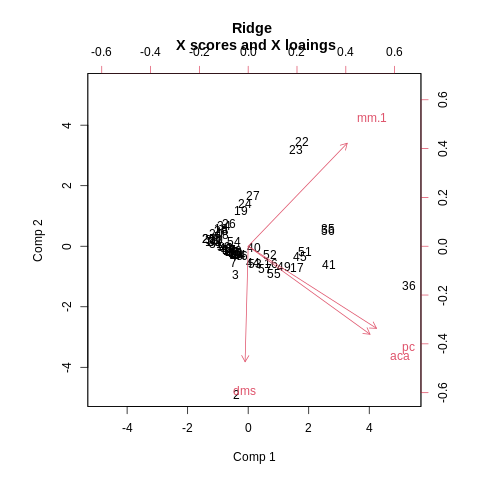

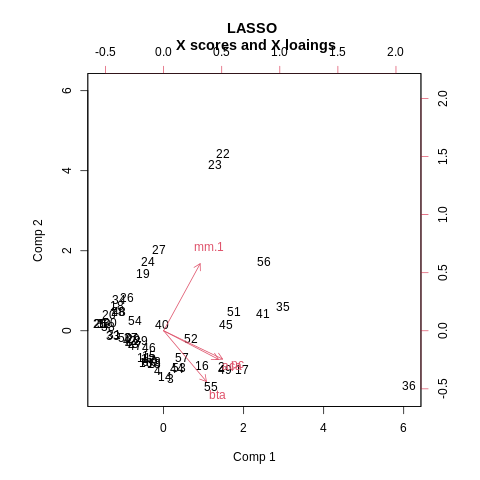

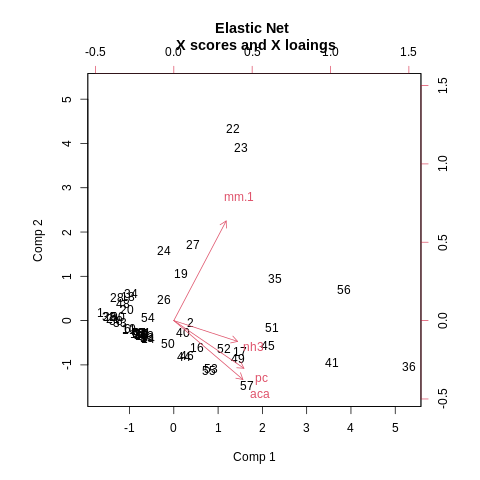

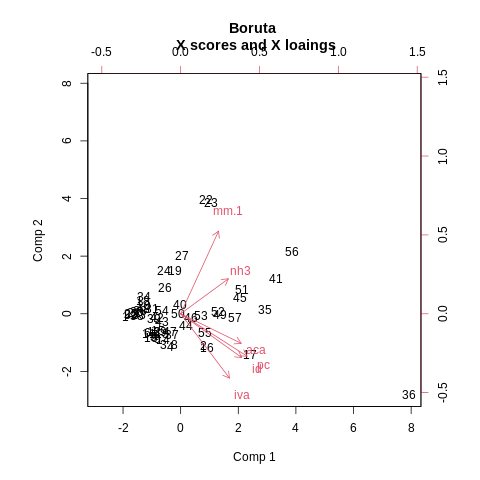

In [139]:
%%R

biplot(pr, var.axes = T, main = "Basic \n X scores and X loaings")
biplot(prr, var.axes = T, main = "Ridge \n X scores and X loaings")
biplot(prl, var.axes = T, main = "LASSO \n X scores and X loaings")
biplot(pre, var.axes = T, main = "Elastic Net \n X scores and X loaings")
biplot(prb, var.axes = T, main = "Boruta \n X scores and X loaings")

## **4. ALL PLS + Regression**

- All components

- "lm" function in R


### **1) Original PLSR (prm)**

In [140]:
%%R

prm <- lm(ou ~ ., data = new_odo)
print(summary(prm))
cat("최적 components 수 :", ocom)


Call:
lm(formula = ou ~ ., data = new_odo)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4199 -0.4972 -0.2031  0.3127  3.6145 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -1.005e-16  1.102e-01   0.000  1.00000   
`Comp 1`     1.511e-01  4.466e-02   3.384  0.00135 **
`Comp 2`     2.674e-01  8.139e-02   3.285  0.00181 **
`Comp 3`     4.285e-01  1.799e-01   2.382  0.02084 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8319 on 53 degrees of freedom
Multiple R-squared:  0.345,	Adjusted R-squared:  0.3079 
F-statistic: 9.305 on 3 and 53 DF,  p-value: 4.827e-05

최적 components 수 : 3

### **2) Ridge PLSR (prrm)**



In [141]:
%%R

prrm <- lm(ou ~ ., data = new_odor)
print(summary(prrm))
cat("최적 components 수 :", ocomr)


Call:
lm(formula = ou ~ ., data = new_odor)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5316 -0.4402 -0.2554  0.2867  3.5191 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.519e-16  1.149e-01   0.000    1.000    
`Comp 1`     4.005e-01  9.161e-02   4.372 5.79e-05 ***
`Comp 2`     1.611e-01  1.096e-01   1.469    0.148    
`Comp 3`     9.123e-02  2.697e-01   0.338    0.737    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8677 on 53 degrees of freedom
Multiple R-squared:  0.2875,	Adjusted R-squared:  0.2472 
F-statistic: 7.128 on 3 and 53 DF,  p-value: 0.0004139

최적 components 수 : 3

### **3) LASSO PLSR (prlm)**

In [142]:
%%R

prlm <- lm(ou ~ ., data = new_odol)
print(summary(prlm))
cat("최적 components 수 :", ocoml)


Call:
lm(formula = ou ~ ., data = new_odol)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4909 -0.5003 -0.2897  0.3735  3.5597 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.367e-16  1.171e-01   0.000 1.000000    
`Comp 1`     3.324e-01  8.397e-02   3.958 0.000226 ***
`Comp 2`     1.753e-01  1.042e-01   1.682 0.098473 .  
`Comp 3`     1.301e-01  3.043e-01   0.428 0.670650    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8839 on 53 degrees of freedom
Multiple R-squared:  0.2606,	Adjusted R-squared:  0.2187 
F-statistic: 6.226 on 3 and 53 DF,  p-value: 0.001058

최적 components 수 : 3

### **4) Elastic Net PLSR (prem)**

In [143]:
%%R

prem <- lm(ou ~ ., data = new_odoe)
print(summary(prem))
cat("최적 components 수 :", ocome)


Call:
lm(formula = ou ~ ., data = new_odoe)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3676 -0.5178 -0.2537  0.3118  3.5492 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.137e-16  1.169e-01   0.000  1.00000    
`Comp 1`     3.361e-01  8.140e-02   4.129  0.00013 ***
`Comp 2`     1.579e-01  1.178e-01   1.340  0.18583    
`Comp 3`     5.488e-02  1.747e-01   0.314  0.75467    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8823 on 53 degrees of freedom
Multiple R-squared:  0.2633,	Adjusted R-squared:  0.2216 
F-statistic: 6.314 on 3 and 53 DF,  p-value: 0.0009647

최적 components 수 : 3

### **5) Boruta PLSR (prbm)**

In [144]:
%%R

prbm <- lm(ou ~ ., data = new_odob)
print(summary(prbm))
cat("최적 components 수 :", ocomb)


Call:
lm(formula = ou ~ ., data = new_odob)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3736 -0.4500 -0.2207  0.3159  3.4883 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.373e-16  1.160e-01   0.000 1.000000    
`Comp 1`     2.633e-01  6.830e-02   3.856 0.000314 ***
`Comp 2`     2.140e-01  1.035e-01   2.067 0.043652 *  
`Comp 3`     1.888e-01  2.005e-01   0.942 0.350665    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8757 on 53 degrees of freedom
Multiple R-squared:  0.2742,	Adjusted R-squared:  0.2331 
F-statistic: 6.675 on 3 and 53 DF,  p-value: 0.0006611

최적 components 수 : 3

### **6) 잔차 검정**

- 전부 등분산성과  독립성은 만족

- But 전부 정규성을 만족하지 못한다.

In [145]:
%%R

# par(mfrow=c(2,2))
# plot(prm)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(prrm)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(prlm)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(prem)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(prbm)
# par(mfrow=c(1,1))

NULL


##### **- 잔차의 등분산성 (Breusch-Pagan test)**

- $H_0$ : 등분산성이다.  vs  $H_1$ : 등분산성이 아니다.

In [146]:
%%R

print(bptest(prm))
print(bptest(prrm))
print(bptest(prlm))
print(bptest(prem))
print(bptest(prbm))


	studentized Breusch-Pagan test

data:  prm
BP = 0.62465, df = 3, p-value = 0.8908


	studentized Breusch-Pagan test

data:  prrm
BP = 1.4941, df = 3, p-value = 0.6836


	studentized Breusch-Pagan test

data:  prlm
BP = 2.3907, df = 3, p-value = 0.4954


	studentized Breusch-Pagan test

data:  prem
BP = 1.2665, df = 3, p-value = 0.7371


	studentized Breusch-Pagan test

data:  prbm
BP = 0.76581, df = 3, p-value = 0.8576



##### **- 잔차의 독립성 (Durbin-Watson test)**

- $H_0$ : 잔차는 독립이다.  vs  $H_1$ : 잔차가 자기상관관계가 있다.

-  DW statistic 값이 2 근처의 값이 나오는 경우 자기상관관계가 없다. (= 독립)

In [147]:
%%R

print(dwtest(prm))
print(dwtest(prrm))
print(dwtest(prlm))
print(dwtest(prem))
print(dwtest(prbm))


	Durbin-Watson test

data:  prm
DW = 1.7726, p-value = 0.1495
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  prrm
DW = 1.6886, p-value = 0.09185
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  prlm
DW = 1.6471, p-value = 0.0685
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  prem
DW = 1.694, p-value = 0.08994
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  prbm
DW = 1.6913, p-value = 0.09063
alternative hypothesis: true autocorrelation is greater than 0



##### **- 잔차의 정규성 (Shapiro-test)**

- $H_0$ : 모집단은 정규분포를 따른다.   vs   $H_1$ : 모집단은 정규분포를 따르지 않는다.

In [148]:
%%R

prm_res <- residuals(prm)
print(shapiro.test(prm_res))

prrm_res <- residuals(prrm)
print(shapiro.test(prrm_res))

prlm_res <- residuals(prlm)
print(shapiro.test(prlm_res))

prem_res <- residuals(prem)
print(shapiro.test(prem_res))

prbm_res <- residuals(prbm)
print(shapiro.test(prbm_res))


	Shapiro-Wilk normality test

data:  prm_res
W = 0.80985, p-value = 4.084e-07


	Shapiro-Wilk normality test

data:  prrm_res
W = 0.80121, p-value = 2.494e-07


	Shapiro-Wilk normality test

data:  prlm_res
W = 0.81702, p-value = 6.212e-07


	Shapiro-Wilk normality test

data:  prem_res
W = 0.79914, p-value = 2.219e-07


	Shapiro-Wilk normality test

data:  prbm_res
W = 0.80345, p-value = 2.83e-07



## **5. BestPLS + Regression**

- Best Components

- "lm" function in R

### **1) Original PLSR (bprm)**

In [149]:
%%R

bprm <- lm(ou ~ ., data = new_odo[,1:(ocom+1)])
print(summary(bprm))
cat("최적 components 수 :", ocom)


Call:
lm(formula = ou ~ ., data = new_odo[, 1:(ocom + 1)])

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4199 -0.4972 -0.2031  0.3127  3.6145 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -1.005e-16  1.102e-01   0.000  1.00000   
`Comp 1`     1.511e-01  4.466e-02   3.384  0.00135 **
`Comp 2`     2.674e-01  8.139e-02   3.285  0.00181 **
`Comp 3`     4.285e-01  1.799e-01   2.382  0.02084 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8319 on 53 degrees of freedom
Multiple R-squared:  0.345,	Adjusted R-squared:  0.3079 
F-statistic: 9.305 on 3 and 53 DF,  p-value: 4.827e-05

최적 components 수 : 3

### **2) Ridge PLSR (bprrm)**



In [150]:
%%R

bprrm <- lm(ou ~ ., data = new_odor[, 1:(ocomr+1)])
print(summary(bprrm))
cat("최적 components 수 :", ocomr)


Call:
lm(formula = ou ~ ., data = new_odor[, 1:(ocomr + 1)])

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5316 -0.4402 -0.2554  0.2867  3.5191 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.519e-16  1.149e-01   0.000    1.000    
`Comp 1`     4.005e-01  9.161e-02   4.372 5.79e-05 ***
`Comp 2`     1.611e-01  1.096e-01   1.469    0.148    
`Comp 3`     9.123e-02  2.697e-01   0.338    0.737    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8677 on 53 degrees of freedom
Multiple R-squared:  0.2875,	Adjusted R-squared:  0.2472 
F-statistic: 7.128 on 3 and 53 DF,  p-value: 0.0004139

최적 components 수 : 3

### **3) LASSO PLSR (bprlm)**

In [151]:
%%R

bprlm <- lm(ou ~ ., data = new_odol[, 1:(ocoml+1)])
print(summary(bprlm))
cat("최적 components 수 :", ocoml)


Call:
lm(formula = ou ~ ., data = new_odol[, 1:(ocoml + 1)])

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4909 -0.5003 -0.2897  0.3735  3.5597 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.367e-16  1.171e-01   0.000 1.000000    
`Comp 1`     3.324e-01  8.397e-02   3.958 0.000226 ***
`Comp 2`     1.753e-01  1.042e-01   1.682 0.098473 .  
`Comp 3`     1.301e-01  3.043e-01   0.428 0.670650    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8839 on 53 degrees of freedom
Multiple R-squared:  0.2606,	Adjusted R-squared:  0.2187 
F-statistic: 6.226 on 3 and 53 DF,  p-value: 0.001058

최적 components 수 : 3

### **4) Elastic Net PLSR (bprem)**

In [152]:
%%R

bprem <- lm(ou ~ ., data = new_odoe[, 1:(ocome+1)])
print(summary(bprem))
cat("최적 components 수 :", ocome)


Call:
lm(formula = ou ~ ., data = new_odoe[, 1:(ocome + 1)])

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3676 -0.5178 -0.2537  0.3118  3.5492 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.137e-16  1.169e-01   0.000  1.00000    
`Comp 1`     3.361e-01  8.140e-02   4.129  0.00013 ***
`Comp 2`     1.579e-01  1.178e-01   1.340  0.18583    
`Comp 3`     5.488e-02  1.747e-01   0.314  0.75467    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8823 on 53 degrees of freedom
Multiple R-squared:  0.2633,	Adjusted R-squared:  0.2216 
F-statistic: 6.314 on 3 and 53 DF,  p-value: 0.0009647

최적 components 수 : 3

### **5) Boruta PLSR (bprbm)**

In [153]:
%%R

bprbm <- lm(ou ~ ., data = new_odob[, 1:(ocomb+1)])
print(summary(bprbm))
cat("최적 components 수 :", ocomb)


Call:
lm(formula = ou ~ ., data = new_odob[, 1:(ocomb + 1)])

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3736 -0.4500 -0.2207  0.3159  3.4883 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.373e-16  1.160e-01   0.000 1.000000    
`Comp 1`     2.633e-01  6.830e-02   3.856 0.000314 ***
`Comp 2`     2.140e-01  1.035e-01   2.067 0.043652 *  
`Comp 3`     1.888e-01  2.005e-01   0.942 0.350665    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8757 on 53 degrees of freedom
Multiple R-squared:  0.2742,	Adjusted R-squared:  0.2331 
F-statistic: 6.675 on 3 and 53 DF,  p-value: 0.0006611

최적 components 수 : 3

### **6) 잔차 검정**

- 전부 등분산성과  독립성은 만족

- But 전부 정규성을 만족하지 못한다.

In [154]:
%%R

# par(mfrow=c(2,2))
# plot(bprm)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(bprrm)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(bprlm)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(bprem)
# par(mfrow=c(1,1))

# par(mfrow=c(2,2))
# plot(bprbm)
# par(mfrow=c(1,1))

NULL


##### **- 잔차의 등분산성 (Breusch-Pagan test)**

- $H_0$ : 등분산성이다.  vs  $H_1$ : 등분산성이 아니다.

In [155]:
%%R

print(bptest(bprm))
print(bptest(bprrm))
print(bptest(bprlm))
print(bptest(bprem))
print(bptest(bprbm))


	studentized Breusch-Pagan test

data:  bprm
BP = 0.62465, df = 3, p-value = 0.8908


	studentized Breusch-Pagan test

data:  bprrm
BP = 1.4941, df = 3, p-value = 0.6836


	studentized Breusch-Pagan test

data:  bprlm
BP = 2.3907, df = 3, p-value = 0.4954


	studentized Breusch-Pagan test

data:  bprem
BP = 1.2665, df = 3, p-value = 0.7371


	studentized Breusch-Pagan test

data:  bprbm
BP = 0.76581, df = 3, p-value = 0.8576



##### **- 잔차의 독립성 (Durbin-Watson test)**

- $H_0$ : 잔차는 독립이다.  vs  $H_1$ : 잔차가 자기상관관계가 있다.

-  DW statistic 값이 2 근처의 값이 나오는 경우 자기상관관계가 없다. (= 독립)

In [156]:
%%R

print(dwtest(bprm))
print(dwtest(bprrm))
print(dwtest(bprlm))
print(dwtest(bprem))
print(dwtest(bprbm))


	Durbin-Watson test

data:  bprm
DW = 1.7726, p-value = 0.1495
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  bprrm
DW = 1.6886, p-value = 0.09185
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  bprlm
DW = 1.6471, p-value = 0.0685
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  bprem
DW = 1.694, p-value = 0.08994
alternative hypothesis: true autocorrelation is greater than 0


	Durbin-Watson test

data:  bprbm
DW = 1.6913, p-value = 0.09063
alternative hypothesis: true autocorrelation is greater than 0



##### **- 잔차의 정규성 (Shapiro-test)**

- $H_0$ : 모집단은 정규분포를 따른다.   vs   $H_1$ : 모집단은 정규분포를 따르지 않는다.

In [157]:
%%R

bprm_res <- residuals(bprm)
print(shapiro.test(bprm_res))

bprrm_res <- residuals(bprrm)
print(shapiro.test(bprrm_res))

bprlm_res <- residuals(bprlm)
print(shapiro.test(bprlm_res))

bprem_res <- residuals(bprem)
print(shapiro.test(bprem_res))

bprbm_res <- residuals(bprbm)
print(shapiro.test(bprbm_res))


	Shapiro-Wilk normality test

data:  bprm_res
W = 0.80985, p-value = 4.084e-07


	Shapiro-Wilk normality test

data:  bprrm_res
W = 0.80121, p-value = 2.494e-07


	Shapiro-Wilk normality test

data:  bprlm_res
W = 0.81702, p-value = 6.212e-07


	Shapiro-Wilk normality test

data:  bprem_res
W = 0.79914, p-value = 2.219e-07


	Shapiro-Wilk normality test

data:  bprbm_res
W = 0.80345, p-value = 2.83e-07



## **6. LOOCV PLSR (Best comp 기준)**

### **- Model 생성**

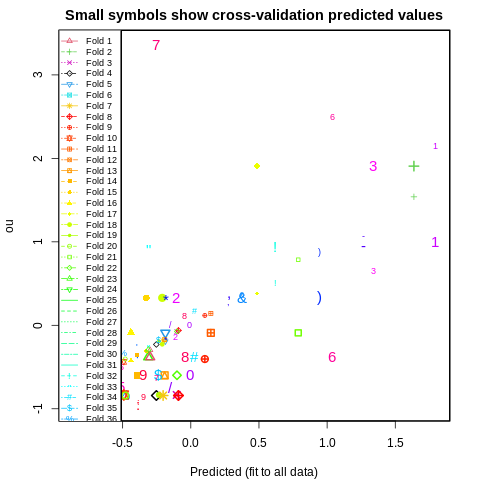

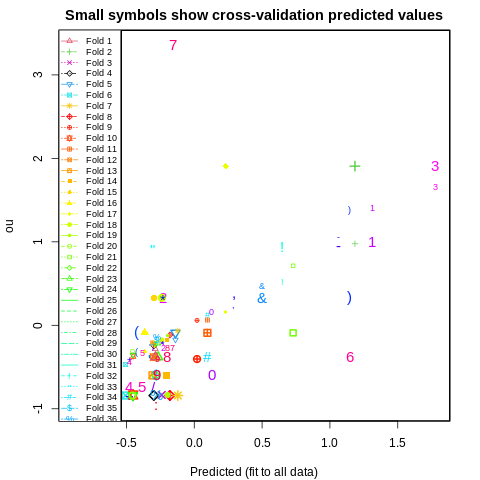

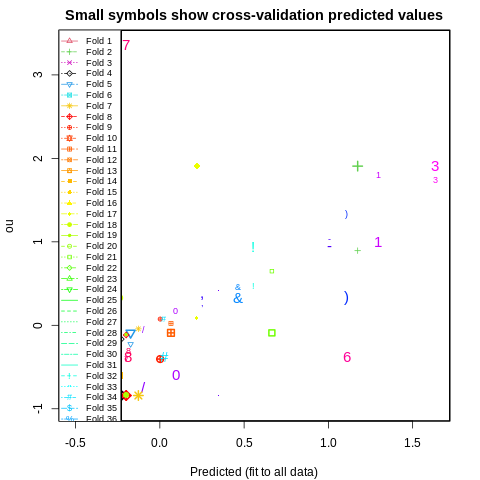

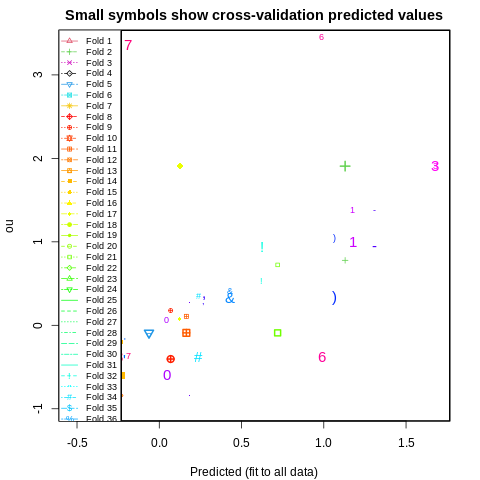

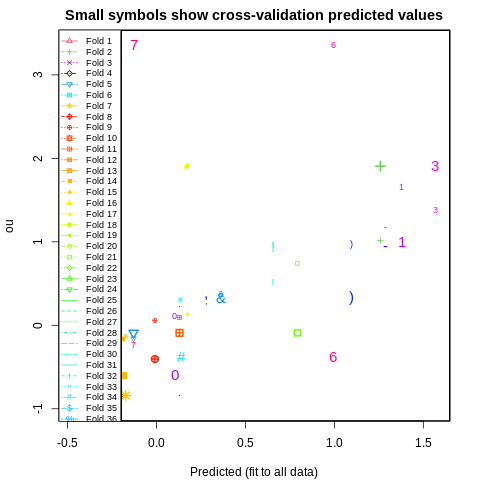

In [158]:
%%R

cv_bprm <- cv.lm(new_odo, form.lm = ou ~ ., m = nrow(new_odo), printit = F)
cv_bprrm <- cv.lm(new_odor, form.lm = ou ~ ., m = nrow(new_odor), printit = F)
cv_bprlm <- cv.lm(new_odol, form.lm = ou ~ ., m = nrow(new_odol), printit = F)
cv_bprem <- cv.lm(new_odoe, form.lm = ou ~ ., m = nrow(new_odoe), printit = F)
cv_bprbm <- cv.lm(new_odob, form.lm = ou ~ ., m = nrow(new_odob), printit = F)

## **7. Results (Best comp 기준)**

### **1) Validation**

In [159]:
%%R

### Log + Standardization Best Components
cvb_vp <- cv_bprm$cvpred
cvbr_vp <- cv_bprrm$cvpred
cvbl_vp <- cv_bprlm$cvpred
cvbe_vp <- cv_bprem$cvpred
cvbb_vp <- cv_bprbm$cvpred

#### **- R-squared**

In [160]:
%%R

### R-squared
y <- odo$ou


### Log + Best
cvb_r2 <- cor(y, cvb_vp)^2
cvbr_r2 <- cor(y, cvbr_vp)^2
cvbl_r2 <- cor(y, cvbl_vp)^2
cvbe_r2 <- cor(y, cvbe_vp)^2
cvbb_r2 <- cor(y, cvbb_vp)^2

cat("R2 - Basic : ", round(cvb_r2, 4), "\n")
cat("R2 - Ridge : ", round(cvbr_r2, 4), "\n")
cat("R2 - LASSO : ", round(cvbl_r2, 4), "\n")
cat("R2 - Elastic Net : ", round(cvbe_r2, 4), "\n")
cat("R2 - Boruta : ", round(cvbb_r2, 4))

R2 - Basic :  0.1567 
R2 - Ridge :  0.0633 
R2 - LASSO :  0.0687 
R2 - Elastic Net :  0.0926 
R2 - Boruta :  0.1016

#### **- RMSE**

\
- $RMSE = \sqrt{{1 \over n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

In [161]:
%%R

### Log + Best
cvb_rmse <- rmse(y, cvb_vp)^2
cvbr_rmse <- rmse(y, cvbr_vp)^2
cvbl_rmse <- rmse(y, cvbl_vp)^2
cvbe_rmse <- rmse(y, cvbe_vp)^2
cvbb_rmse <- rmse(y, cvbb_vp)^2

cat("rmse - Basic : ", round(cvb_rmse, 4), "\n")
cat("rmse - Ridge : ", round(cvbr_rmse, 4), "\n")
cat("rmse - LASSO : ", round(cvbl_rmse, 4), "\n")
cat("rmse - Elastic Net : ", round(cvbe_rmse, 4), "\n")
cat("rmse - Boruta : ", round(cvbb_rmse, 4))

rmse - Basic :  0.8885 
rmse - Ridge :  1.2557 
rmse - LASSO :  1.1411 
rmse - Elastic Net :  1.0324 
rmse - Boruta :  0.9936

#### **- MAPE**

\
- Mean Absolute Precentage Error

\
- $MAPE = {100 \over n} \sum_{t=1}^n |{A_t - F_t \over A_t}|$

  - $A_t$ : True Value
  - $F_t$ : Predicted Value

In [162]:
%%R

### Log + Best
cvb_mape <- mape(cvb_vp, y)^2
cvbr_mape <- mape(cvbr_vp, y)^2
cvbl_mape <- mape(cvbl_vp, y)^2
cvbe_mape <- mape(cvbe_vp, y)^2
cvbb_mape <- mape(cvbb_vp, y)^2

cat("mape - Basic : ", round(cvb_mape, 4), "\n")
cat("mape - Ridge : ", round(cvbr_mape, 4), "\n")
cat("mape - LASSO : ", round(cvbl_mape, 4), "\n")
cat("mape - Elastic Net : ", round(cvbe_mape, 4), "\n")
cat("mape - Boruta : ", round(cvbb_mape, 4))

mape - Basic :  95.6211 
mape - Ridge :  332.3808 
mape - LASSO :  28.7137 
mape - Elastic Net :  19.4782 
mape - Boruta :  129.0015

#### **- Predplot**

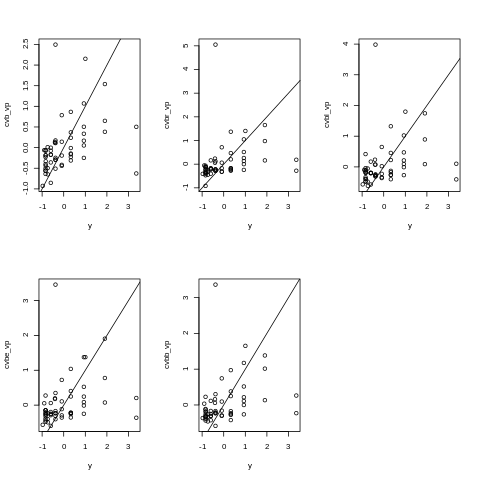

In [163]:
%%R

par(mfrow = c(2,3))
plot(y, cvb_vp) ; abline(a = 0, b = 1)
plot(y, cvbr_vp) ; abline(a = 0, b = 1)
plot(y, cvbl_vp) ; abline(a = 0, b = 1)
plot(y, cvbe_vp) ; abline(a = 0, b = 1)
plot(y, cvbb_vp) ; abline(a = 0, b = 1)
par(mfrow = c(1,1))

### **2) Fitted**

In [164]:
%%R

### Log + Standardization Best Components
cvb_fp <- cv_bprm$Predicted
cvbr_fp <- cv_bprrm$Predicted
cvbl_fp <- cv_bprlm$Predicted
cvbe_fp <- cv_bprem$Predicted
cvbb_fp <- cv_bprbm$Predicted

#### **- R-squared**

In [165]:
%%R

### R-squared
y <- odo$ou


### Log + Best
cvb_fr2 <- cor(y, cvb_fp)^2
cvbr_fr2 <- cor(y, cvbr_fp)^2
cvbl_fr2 <- cor(y, cvbl_fp)^2
cvbe_fr2 <- cor(y, cvbe_fp)^2
cvbb_fr2 <- cor(y, cvbb_fp)^2

cat("R2 - Basic : ", round(cvb_fr2, 4), "\n")
cat("R2 - Ridge : ", round(cvbr_fr2, 4), "\n")
cat("R2 - LASSO : ", round(cvbl_fr2, 4), "\n")
cat("R2 - Elastic Net : ", round(cvbe_fr2, 4), "\n")
cat("R2 - Boruta : ", round(cvbb_fr2, 4))

R2 - Basic :  0.345 
R2 - Ridge :  0.2875 
R2 - LASSO :  0.2606 
R2 - Elastic Net :  0.2633 
R2 - Boruta :  0.2742

#### **- RMSE**

\
- $RMSE = \sqrt{{1 \over n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

In [166]:
%%R

### Log + Best
cvb_frmse <- rmse(y, cvb_fp)^2
cvbr_frmse <- rmse(y, cvbr_fp)^2
cvbl_frmse <- rmse(y, cvbl_fp)^2
cvbe_frmse <- rmse(y, cvbe_fp)^2
cvbb_frmse <- rmse(y, cvbb_fp)^2

cat("rmse - Basic : ", round(cvb_frmse, 4), "\n")
cat("rmse - Ridge : ", round(cvbr_frmse, 4), "\n")
cat("rmse - LASSO : ", round(cvbl_frmse, 4), "\n")
cat("rmse - Elastic Net : ", round(cvbe_frmse, 4), "\n")
cat("rmse - Boruta : ", round(cvbb_frmse, 4))

rmse - Basic :  0.6435 
rmse - Ridge :  0.7 
rmse - LASSO :  0.7264 
rmse - Elastic Net :  0.7238 
rmse - Boruta :  0.7131

#### **- MAPE**

\
- Mean Absolute Precentage Error

\
- $MAPE = {100 \over n} \sum_{t=1}^n |{A_t - F_t \over A_t}|$

  - $A_t$ : True Value
  - $F_t$ : Predicted Value

In [167]:
%%R

### Log + Best
cvb_fmape <- mape(cvb_fp, y)^2
cvbr_fmape <- mape(cvbr_fp, y)^2
cvbl_fmape <- mape(cvbl_fp, y)^2
cvbe_fmape <- mape(cvbe_fp, y)^2
cvbb_fmape <- mape(cvbb_fp, y)^2

cat("mape - Basic : ", round(cvb_fmape, 4), "\n")
cat("mape - Ridge : ", round(cvbr_fmape, 4), "\n")
cat("mape - LASSO : ", round(cvbl_fmape, 4), "\n")
cat("mape - Elastic Net : ", round(cvbe_fmape, 4), "\n")
cat("mape - Boruta : ", round(cvbb_fmape, 4))

mape - Basic :  18.388 
mape - Ridge :  30.7814 
mape - LASSO :  49.3958 
mape - Elastic Net :  8.4375 
mape - Boruta :  13.0729

#### **- Predplot**

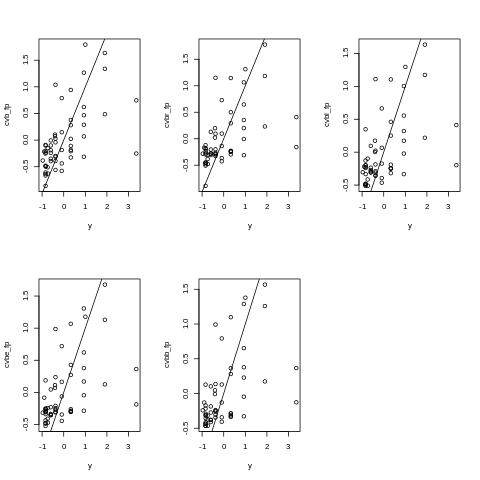

In [168]:
%%R

par(mfrow = c(2,3))
plot(y, cvb_fp) ; abline(a = 0, b = 1)
plot(y, cvbr_fp) ; abline(a = 0, b = 1)
plot(y, cvbl_fp) ; abline(a = 0, b = 1)
plot(y, cvbe_fp) ; abline(a = 0, b = 1)
plot(y, cvbb_fp) ; abline(a = 0, b = 1)
par(mfrow = c(1,1))

### **3) 결과 정리**

In [169]:
%%R

R2 <- c(cvb_r2, cvbr_r2, cvbl_r2, cvbe_r2, cvbb_r2)
R2 <- as.data.frame(round(R2, 3))
colnames(R2) <- "R2"
rownames(R2) <- c("Original", "Ridge", "LASSO", "Elastic Net", "Boruta")

RMSE <- c(cvb_rmse, cvbr_rmse, cvbl_rmse, cvbe_rmse, cvbb_rmse)
RMSE <- as.data.frame(round(RMSE, 3))
colnames(RMSE) <- "RMSE"
rownames(RMSE) <- c("Original", "Ridge", "LASSO", "Elastic Net", "Boruta")

MAPE <- c(cvb_mape, cvbr_mape, cvbl_mape, cvbe_mape, cvbb_mape)
MAPE <- as.data.frame(round(MAPE,3))
colnames(MAPE) <- "MAPE"
rownames(MAPE) <- c("Original", "Ridge", "LASSO", "Elastic Net", "Boruta")

pls_valid_results <- cbind(R2, RMSE, MAPE)
pls_valid_results

               R2  RMSE    MAPE
Original    0.157 0.889  95.621
Ridge       0.063 1.256 332.381
LASSO       0.069 1.141  28.714
Elastic Net 0.093 1.032  19.478
Boruta      0.102 0.994 129.002


In [170]:
%%R

FR2 <- c(cvb_fr2, cvbr_fr2, cvbl_fr2, cvbe_fr2, cvbb_fr2)
FR2 <- as.data.frame(round(FR2, 3))
colnames(FR2) <- "FR2"
rownames(FR2) <- c("Original", "FRidge", "LASSO", "Elastic Net", "Boruta")

FRMSE <- c(cvb_frmse, cvbr_frmse, cvbl_frmse, cvbe_frmse, cvbb_frmse)
FRMSE <- as.data.frame(round(FRMSE, 3))
colnames(FRMSE) <- "FRMSE"
rownames(FRMSE) <- c("Original", "FRidge", "LASSO", "Elastic Net", "Boruta")

FMAPE <- c(cvb_fmape, cvbr_fmape, cvbl_fmape, cvbe_fmape, cvbb_fmape)
FMAPE <- as.data.frame(round(FMAPE, 3))
colnames(FMAPE) <- "FMAPE"
rownames(FMAPE) <- c("Original", "FRidge", "LASSO", "Elastic Net", "Boruta")

pls_fitted_results <- cbind(FR2, FRMSE, FMAPE)
pls_fitted_results

              FR2 FRMSE  FMAPE
Original    0.345 0.644 18.388
FRidge      0.287 0.700 30.781
LASSO       0.261 0.726 49.396
Elastic Net 0.263 0.724  8.438
Boruta      0.274 0.713 13.073


In [171]:
%%R

Results <- cbind(pls_valid_results, pls_fitted_results)
# Results

write.csv(Results, file = "drive/MyDrive/PLS_양돈 농가/(Results) PLS.csv")

check_Results <- read.csv("drive/MyDrive/PLS_양돈 농가/(Results) PLS.csv", fileEncoding = "euc-kr", row.names = 1)
check_Results

               R2  RMSE    MAPE   FR2 FRMSE  FMAPE
Original    0.157 0.889  95.621 0.345 0.644 18.388
Ridge       0.063 1.256 332.381 0.287 0.700 30.781
LASSO       0.069 1.141  28.714 0.261 0.726 49.396
Elastic Net 0.093 1.032  19.478 0.263 0.724  8.438
Boruta      0.102 0.994 129.002 0.274 0.713 13.073
